In [3]:
from transformers import XLNetModel, AutoTokenizer, pipeline, XLNetForSequenceClassification
import pandas as pd
from torch.utils.data import Dataset
import torch
from sklearn.preprocessing import LabelEncoder

In [25]:
df = pd.read_csv("cleaned_file.csv")
df.head()

,text,label,category
0,FLASH SALE | LIMITED TIME ONLY Shop Now,1,Urgency
1,Pillowcases & Shams,0,Not Dark Pattern
2,Write a review,0,Not Dark Pattern
3,"To start your return, simply click on the foll...",0,Not Dark Pattern
4,newsletter signup (privacy policy),0,Not Dark Pattern


In [26]:
df.drop("label", axis=1, inplace=True)

In [27]:
df.head()

,text,category
0,FLASH SALE | LIMITED TIME ONLY Shop Now,Urgency
1,Pillowcases & Shams,Not Dark Pattern
2,Write a review,Not Dark Pattern
3,"To start your return, simply click on the foll...",Not Dark Pattern
4,newsletter signup (privacy policy),Not Dark Pattern


In [28]:
fine = df['category'].unique().tolist()
fine = [s.strip() for s in fine]
fine

['Urgency',
 'Not Dark Pattern',
 'Scarcity',
 'Misdirection',
 'Social Proof',
 'Obstruction',
 'Sneaking',
 'Forced Action']

In [29]:
num_fine = len(fine)
id2fine = {id:fine for id, fine in enumerate(fine)}
fine2id = {fine:id for id, fine in enumerate(fine)}

In [30]:
id2fine

{0: 'Urgency',
 1: 'Not Dark Pattern',
 2: 'Scarcity',
 3: 'Misdirection',
 4: 'Social Proof',
 5: 'Obstruction',
 6: 'Sneaking',
 7: 'Forced Action'}

In [31]:
fine2id

{'Urgency': 0,
 'Not Dark Pattern': 1,
 'Scarcity': 2,
 'Misdirection': 3,
 'Social Proof': 4,
 'Obstruction': 5,
 'Sneaking': 6,
 'Forced Action': 7}

In [32]:
df['labels'] = df.category.map(lambda x: fine2id[x.strip()])
df

,text,category,labels
0,FLASH SALE | LIMITED TIME ONLY Shop Now,Urgency,0
1,Pillowcases & Shams,Not Dark Pattern,1
2,Write a review,Not Dark Pattern,1
3,"To start your return, simply click on the foll...",Not Dark Pattern,1
4,newsletter signup (privacy policy),Not Dark Pattern,1
...,...,...,...
3863,TWO FREE PILLOWS AND 30% OFF WITH PROMO CODE,Misdirection,3
3864,Compare at,Misdirection,3
3865,$132.90 $99.00,Misdirection,3
3866,This offer is only VALID if you add to cart now!,Misdirection,3


<Axes: ylabel='count'>

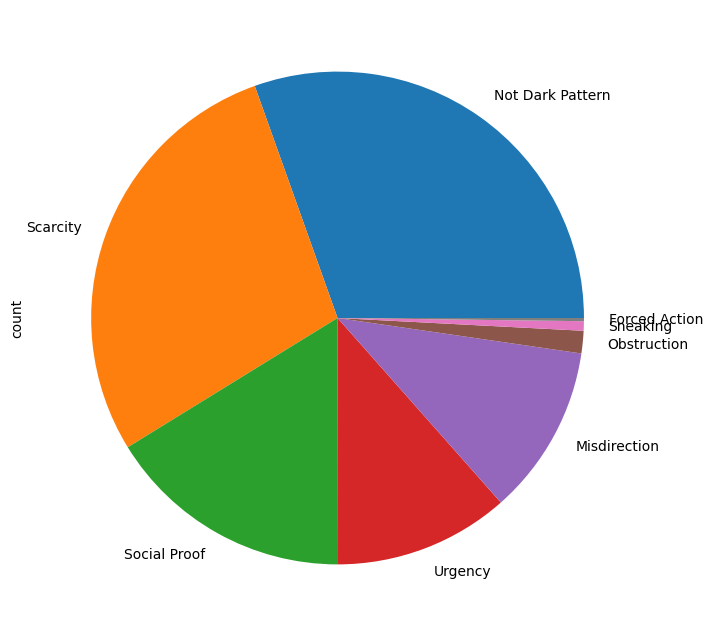

In [33]:
df.category.value_counts().plot(kind="pie", figsize=(8,8))

In [34]:
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

In [35]:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=num_fine, id2label=id2fine, label2id=fine2id)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [36]:
SIZE = df.shape[0]
train_texts = list(df.text[:SIZE//2])
val_texts = list(df.text[SIZE//2:(3*SIZE)//4])
test_texts = list(df.text[(3*SIZE)//4:])
train_labels = list(df.labels[:SIZE//2])
val_labels = list(df.labels[SIZE//2:(3*SIZE)//4])
test_labels = list(df.labels[(3*SIZE)//4:])

In [37]:
len(train_texts), len(val_texts), len(test_texts)

(1934, 967, 967)

In [38]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [39]:
class Dataloader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [40]:
train_dataloader = Dataloader(train_encodings, train_labels)
val_dataloader = Dataloader(val_encodings, val_labels)
test_dataloader = Dataloader(test_encodings, test_labels)

In [41]:
from transformers import TrainingArguments, Trainer

In [42]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [43]:
!pip install transformers[torch] -U
!pip install accelerate -U


ERROR: Invalid requirement: 'accelerate\xa0-U'


In [47]:
training_args = TrainingArguments(
    output_dir="./XlBERTModel",
    do_train=True,
    do_eval=True,

    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,

    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy="steps",

    logging_dir="./multi-class-logs",
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=False,
    load_best_model_at_end=True,
)


In [48]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,

    # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics=compute_metrics
)


In [49]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.679400,1.443377,0.264736,0.125178,0.263524,0.180177
100,0.726900,0.222247,0.952430,0.690611,0.705301,0.682811
150,0.277000,0.201904,0.944157,0.687070,0.701199,0.680426
200,0.263800,0.170898,0.961737,0.677052,0.728570,0.654530
250,0.225900,0.129024,0.972079,0.715126,0.717157,0.713392
300,0.093100,0.154001,0.972079,0.712873,0.713808,0.712162
350,0.112600,0.143690,0.975181,0.716266,0.714968,0.717606


C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarn

TrainOutput(global_step=363, training_loss=0.4701557740692265, metrics={'train_runtime': 16929.3283, 'train_samples_per_second': 0.343, 'train_steps_per_second': 0.021, 'total_flos': 774823884710400.0, 'train_loss': 0.4701557740692265, 'epoch': 3.0})

In [52]:

def predict(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs['logits'].softmax(1)
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label

    # Since pred_label_idx is a tensor containing a single value (the predicted class index),
    # the .item() method is used to extract the value as a scalar

    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label



In [54]:
model_path = "DPBH_XLNet_Fine_Tuned_Model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('DPBH_XLNet_Fine_Tuned_Model\\tokenizer_config.json',
 'DPBH_XLNet_Fine_Tuned_Model\\special_tokens_map.json',
 'DPBH_XLNet_Fine_Tuned_Model\\tokenizer.json')

In [4]:
# Reload the model

model_path = "DPBH_XLNet_Fine_Tuned_Model"

model = XLNetForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [56]:
nlp("Haris just bought an underwear at just rs 99")

[{'label': 'Social Proof', 'score': 0.9989678859710693}]

In [58]:
nlp("i dont want any knowledge")

[{'label': 'Misdirection', 'score': 0.9988980293273926}]

In [5]:
nlp("I want to buy and eat some ice cream today.")

[{'label': 'Misdirection', 'score': 0.9887610077857971}]